In [21]:
import gmsh
import numpy as np
import meshio
import matplotlib.pyplot as plt
import importlib
import functions as func

importlib.reload(func)

import contextlib
import os
from urllib.request import urlretrieve

from scipy.integrate import solve_ivp
from sympy import *


#### Breakwater parameters

In [22]:
# Domain parameters
seaside = 10  # Length of the domain in x-direction
roof = 13  # Length of the domain in y-direction (roof of the crownwall)
top = 10 # top of the caisson
wall = 8 # location of the left side of the crownwall
tip = 1 # tip of the crownwall


#### Mesh definition

In [23]:
gmsh.initialize()
gmsh.model.add("Breakwater")

# Tag offset
tag = 1


# Mesh size
lc_big = 0.8
lc_small = 0.4

p_center = gmsh.model.geo.addPoint(seaside+tip, roof-2*tip, 0, lc_small, tag); tag += 1

# Outer rectangle points
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc_big, tag); tag += 1
p2 = gmsh.model.geo.addPoint(0, top, 0, lc_big, tag); tag += 1
p3 = gmsh.model.geo.addPoint(wall, top, 0, lc_small, tag); tag += 1
p4 = gmsh.model.geo.addPoint(wall, roof, 0, lc_small, tag); tag += 1
p5 = gmsh.model.geo.addPoint(seaside+tip, roof, 0, lc_small, tag); tag += 1
p6 = gmsh.model.geo.addPoint(seaside+tip, roof-tip, 0, lc_small, tag); tag += 1
p7 = gmsh.model.geo.addPoint(seaside, roof-2*tip, 0, lc_small, tag); tag += 1
p8 = gmsh.model.geo.addPoint(seaside, 0, 0, lc_big, tag); tag += 1

# Outer rectangle lines
l_a = gmsh.model.geo.addLine(p1, p2)
l_b = gmsh.model.geo.addLine(p2, p3)
l_c = gmsh.model.geo.addLine(p3, p4)
l_d = gmsh.model.geo.addLine(p4, p5)
l_e = gmsh.model.geo.addLine(p5, p6)
l_f = gmsh.model.geo.addCircleArc(p6, p_center, p7)
l_g = gmsh.model.geo.addLine(p7, p8)
l_h = gmsh.model.geo.addLine(p8, p1)


# Define surface with a hole
outer_loop = gmsh.model.geo.addCurveLoop([l_a, l_b, l_c, l_d, l_e, l_f, l_g, l_h])
surface = gmsh.model.geo.addPlaneSurface([outer_loop])

gmsh.model.geo.synchronize()

# # Define physical group for the interior domain
interior_tag = 3  # Assign a physical group ID
gmsh.model.addPhysicalGroup(2, [surface], interior_tag)  # 2 corresponds to surface dimension

sea_side_tag = 1  # Assign a physical group ID
gmsh.model.addPhysicalGroup(1, [l_f, l_g, l_e], sea_side_tag)  # 1 to the line segment

# # Define physical boundary for the left vertical side (l4)
bottom_side_tag = 2  # Assign a physical group ID
gmsh.model.addPhysicalGroup(1, [l_h], bottom_side_tag)  # 1 to the line segment

# Generate the mesh
# gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
gmsh.write("Breakwater.msh")

#### Mesh plotting & boundary visualization

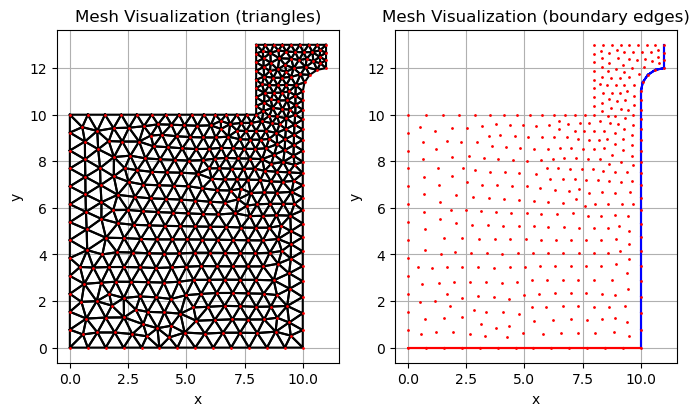

In [24]:
# Read mesh from file
mesh = meshio.read("Breakwater.msh")

# Extract node coordinates and triangle connectivity
points = mesh.points[:, :2]  # (x, y)
triangles = mesh.get_cells_type("triangle")
groups = mesh.get_cell_data("gmsh:physical", "line")
# edges = mesh.get_cells_type("line") # edges on the left boundary
# edges = mesh.cells_dict.get(2, [])  # edges on the left boundary
bottom_edges = mesh.get_cells_type("line")[groups == bottom_side_tag]
sea_edges = mesh.get_cells_type("line")[groups == sea_side_tag]

# Plot triangles
fig, ax = plt.subplots(1,2, figsize=(8, 8))
for tri in triangles:
    coords = points[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    ax[0].plot(coords[:, 0], coords[:, 1], 'k-')
ax[0].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[0].set_aspect('equal')
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Mesh Visualization (triangles)")
ax[0].grid(True)

# Plot edges
for edge in sea_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'blue', label = "ver")
for edge in bottom_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'red', label = "hor")
ax[1].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[1].set_aspect('equal')
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Mesh Visualization (boundary edges)")
ax[1].grid(True)
plt.show()


#### Testing gauspoints

In [25]:
# #Testing Triangle

# def f(x, y):
#     return x * y

# gps1, weights1 = GaussPoints(1)
# int1 = sum(f(gps1[i, 0], gps1[i, 1]) * weights1[i] for i in range(len(weights1)))
# print("Integral of f(x,y) over the triangle", int1, "should be:", 1/24)

# gps3, weights3 = GaussPoints(3)
# int3 = sum(f(gps3[i, 0], gps3[i, 1]) * weights3[i] for i in range(len(weights3)))
# print("Integral of f(x,y) over the triangle", int3, "should be:", 1/24)


#### Parameters and boundary condtions

In [26]:
# Problem parameters
E = 36e9  # Young's modulus in Pa
nu = 0.3  # Poisson's ratio
k_bottom = 5
density = 2500  # Density in kg/m^3
# body_force = np.array([0, -9.81 * density])  # Body force (gravity)
body_force = np.array([0, 0])  # Body force (gravity)
C = func.elasticity_tensor(E, nu)
Force = 1

# Assemble the global stiffness matrix, mass matrix, and force vector
K, M, f = func.assemble(mesh, triangles, points, C, density, body_force)

# Find the nodes on the foundation (bottom) boundary
bottom_Bnodes = np.where(np.isin(points[:, 1], points[bottom_edges[:, 1], 0]))[0]
bottom_dofs = np.array([[2*n, 2*n+1] for n in bottom_Bnodes]).flatten()

# Find the nodes on the seaside boundary
sea_Bnodes = np.where(np.isin(points[:, 0], points[sea_edges[:, 0], 0]))[0]
sea_Bnodes = [int(x) for x in sea_Bnodes if x not in bottom_Bnodes] # exlcude bottom node(s) from seaside nodes
sea_dofs = np.array([[2*n, 2*n+1] for n in sea_Bnodes]).flatten()

# Apply the stiffness, mass
for dof in bottom_dofs:
    K[dof, :] = 0  # Set the row to zero
    K[dof, dof] += k_bottom
    M[dof, :] = 0  # Set the row to zero
    M[dof, dof] = 1  # Set the diagonal to 1
    f[dof] = 0  # Set the force vector to


for dof in sea_dofs:
    K[dof, :] = 0  # Set the row to zero
    K[dof, dof] = 1  # Set the diagonal to 1
    M[dof, :] = 0  # Set the row to zero
    M[dof, dof] = 1  # Set the diagonal to 1
    f[dof] = -1e-3  # Set the force vector to



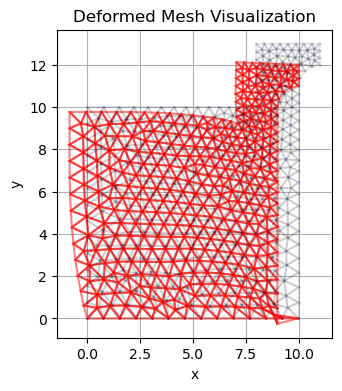

In [27]:
# Solve the system of equations
u = np.linalg.solve(K, f)

# Reshape the solution vector into a 2D array for visualization and magnify by 1e3
u_reshaped = u.reshape(-1, 2) * 1e3


# Plot the deformed mesh
plt.figure(figsize=(8, 4))
for tri in triangles:
    coords = points[tri]
    coords_displaced = coords + u_reshaped[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    coords_displaced = np.vstack((coords_displaced, coords_displaced[0]))  # close the triangle
    plt.plot(coords[:, 0], coords[:, 1], 'k-', alpha=0.1)
    plt.plot(coords_displaced[:,0],coords_displaced[:,1], 'r-', alpha=0.5)
plt.plot(points[:, 0], points[:, 1], 'bo', markersize=1, alpha =0.1)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Deformed Mesh Visualization")
plt.grid(True)
plt.show()

y_new [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0
point: 0.0
y1 0.0 y2 0.0
delta y: 0.0

[0.001 0.001]
F: 0.0


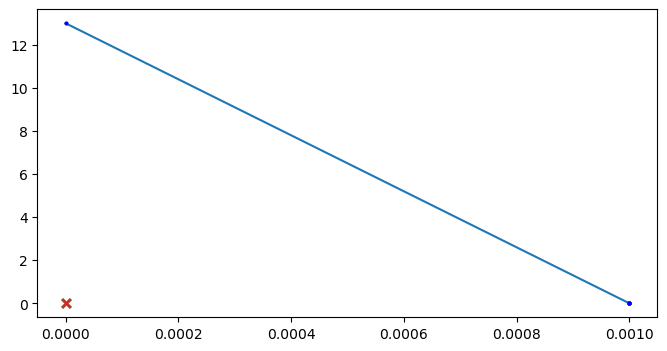

In [28]:
n = 2

y = np.linspace(0, roof, n)
q = np.linspace(1, 0, n)/1000

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(q, y)

y_new = points[bottom_Bnodes][:,1]
y_sor = np.sort(y_new)
print("y_new", y_sor)
q_new = np.interp(y_new, y, q)

ax.plot(q_new, y_new, 'ro', markersize=2, label='Interpolated Points')
ax.plot(q, y, 'bo', label='Original Points', markersize=2)

from scipy.integrate import trapezoid
for i in range(len(q_new)):
    print(f"point: {y_sor[i]}")
    if i == 0:
        y1 = y_sor[i]
    elif i > 0:
        y1 = ((y_sor[i] - y_sor[i-1])/2) + y_sor[i]
    if i < len(q_new)-1:
        y2 = y_sor[i] - ((y_sor[i + 1] - y_sor[i])/2)
    elif i == len(q_new) - 1:
        y2 = y_sor[i]
    print("y1", y1, "y2", y2)
    print(f"delta y: {y1- y2}")
    print("")
    q_i = np.interp([y1, y2], y, q)
    print(q_i)
    F = trapezoid(q_i, [y1, y2])
    print(f"F: {F}")
    ax.scatter(F, y_sor[i], marker='x')




In [43]:
def goda(beta, alpha1, alpha2, alpha3, labda1, labda2, H, l, L, rho, g, eta, hc):
    # beta = wave angle of attack
    # H =  wave height
    # eta = wave height crest elevation
    # hc = crest elevation of the wall (from SWL to top of breakwater or point of interest)
    # labda = wave reflection/transmission coefficients, lecture notes
    # alpha = empirical model coefficients, lecture notes
    # L = wave length
    # l = 
    # hc = 
   
    p1 = 1/2 * (np.cos(beta) + 1) * (alpha1 * labda1 + alpha2 * labda2 *(np.cos(beta)) ** 2) * rho * g * H
    p2 = p1 * (eta - hc) / eta
    p3 = alpha3 * p1
    p3til = 5848 * H * l / (L ** 2) + 9.75
    p2til = 0.45 * p3til
    P1 = p1
    P2 = p2 * (1 + p2til)
    P3 = p3 * (1 + p3til)
    return [P1, P2, P3]

def array_Goda(d, h1, h2, goda):
    # returns array starting from the bottom to the top
    P1 =  goda[0]
    P2 = goda[1]
    P3 = goda[2]
    Pv = []
    # d = SWL
    # h1 = height wrt SWL until curvature
    # h2 = height wrt SWL to highest point
    z = np.linspace(-d, h2, 1000)
    for i in range(len(z)):
        if z[i] < 0:
            P = P1
            Pv.append(P)
        elif z[i]> h1:
            P = (P3 - P2) / (h2 - h1) * (z[i] - h1) + P2
            Pv.append(P)
        else:
            P = (P2 - P1) / (h1) * z[i] + P1
            Pv.append(P)
    return Pv


Testing Goda

In [ ]:
# examples of input values
beta = 2
alpha1 = 0.05
alpha2 = 1
alpha3 = 0.8
H = 2
labda1 = 4
labda2 = 2
l = 15
L = 15
rho = 1025 # density of salt water
g = 9.81
eta = 1 # time dependent factor
hc = 0.5 # needs to be smaller than eta, otherwise negative P2

d = 10
h1 = 3
h2 = 3.5
# alpha1 = 0.1 * 1/2 * (2 * k * h / (np.sinh(2 * k * h))) ** 2
# #For shallow water: alpha1 = 0, for deep water: alpha = 0.05

# alpha2 = min((hb - d) / (3 * hb) * (Hmax /d) **2, 2 * d / Hmax)


# alpha3 = 1 - h_ / h * (1 - 1/(np.cosh(k * h)))

[np.float64(3207.5433058076023), np.float64(571371.7173509051), np.float64(2028407.6193486506)]
[np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.float64(3207.5433058076023), np.floa

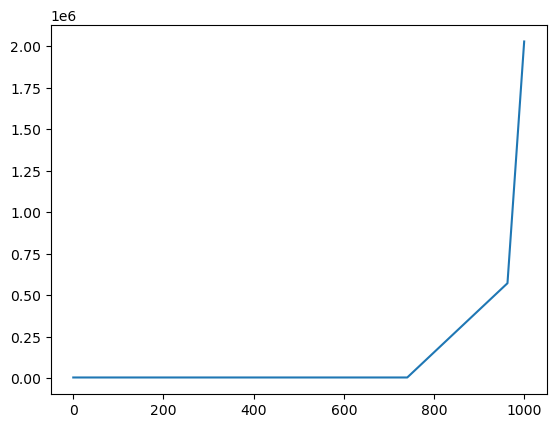

In [60]:
A = goda(beta, alpha1, alpha2, alpha3, labda1, labda2, H, l, L, rho, g, eta, hc)
print(A)

array = array_Goda(d, h1, h2, A)
print(array)

x = np.linspace(0, len(array), len(array))
plt.plot(x, array)

In [ ]:
dt = 0.1 # timestep
T = 10 # total time
time_steps = np.arange(1, T, dt)

# Force applied to the system
f[dof] = -1e-3

# Initial conditions
u = np.zeros_like(f)        # displacement
v = np.zeros_like(f)        # velocity
a = np.zeros_like(f)        # acceleration


# Damping is set to 0
C_damp = np.zeros_like(K)

In [ ]:
u = []
for t in time_steps:
    f = f * np.sin(2 * np.pi * t)
    u_new = np.linalg.solve(K, f)
    u_new_reshaped = u_new.reshape(-1, 2) * 1e3
    print(u_new_reshaped)

    for tri in triangles:
        coords = points[tri]
        coords_displaced = coords + u_new_reshaped[tri]
        coords = np.vstack((coords, coords[0]))  # close the triangle
        coords_displaced = np.vstack((coords_displaced, coords_displaced[0]))  # close the triangle